In [1]:
import os
os.chdir('..')

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [3]:
RESULTS_DIR = "results/movielens_evaluation_v10"

In [4]:
p = Path(RESULTS_DIR)

In [5]:
pickle_paths = p.glob("./*.pickle")

In [6]:
pickle_paths

<generator object Path.glob at 0x10f9842e0>

## Extract the data

In [7]:
reward_dict = {}
ndcg_dict = {}
time_dict = {}
for i, p in enumerate(pickle_paths):
    with open(p, "rb") as f:
        d = pickle.load(f)
    stats_dict = d[0][0]
    one_rew_dict = d[1]
    one_ndcg_dict = d[2]
    for key in one_rew_dict:
        rew_list = one_rew_dict[key]
        ndcg_list = one_ndcg_dict[key]
        mean_rew = np.mean(np.stack(rew_list), axis=0)
        mean_ndcg = np.mean(np.stack(ndcg_list), axis=0)
        reward_dict[key] = mean_rew
        ndcg_dict[key] = mean_ndcg
        assert key == stats_dict[0]
        time_dict[key] = stats_dict[1]['Time mean']

In [8]:
list(reward_dict.keys())

['D-LinTS-RP (d=120, gamma=0.99, a=0.1)',
 'CBRAP (d=12, alpha=0.6)',
 'E-Greedy (epsilon=0.001)',
 'DeepFM',
 'D-LinTS-RP (d=24, gamma=0.99, a=0.1)',
 'CBRAP (d=60, alpha=0.6)',
 'LinearTS (nu=0.3)',
 'CBRAP (d=120, alpha=0.6)',
 'D-LinTS-RP (d=6, gamma=0.99, a=0.1)',
 'LinUCB (alpha=0.7)',
 'CBRAP (d=24, alpha=0.6)',
 'D-LinTS-RP (d=12, gamma=0.99, a=0.1)',
 'RandomPolicy',
 'DLinTS (gamma=0.99, a=0.1)',
 'CBRAP (d=6, alpha=0.6)',
 'D-LinTS-RP (d=60, gamma=0.99, a=0.1)']

## Rename the policies

In [9]:
new_reward_dict = {
#     'D-LinTS-RP (d=120)': reward_dict['D-LinTS-RP (d=120, gamma=0.99, a=0.1)'],
#     'CBRAP (d=12)': reward_dict['CBRAP (d=12, alpha=0.6)'],
    r'$\epsilon$-Greedy':  reward_dict['E-Greedy (epsilon=0.001)'],
    'DeepFM': reward_dict['DeepFM'],
    'D-LinTS-RP (d=24)': reward_dict['D-LinTS-RP (d=24, gamma=0.99, a=0.1)'],
    'CBRAP (d=60)': reward_dict['CBRAP (d=60, alpha=0.6)'],
    'LinTS': reward_dict['LinearTS (nu=0.3)'],
#     'CBRAP (d=120)': reward_dict['CBRAP (d=120, alpha=0.6)'],
#     'D-LinTS-RP (d=6)': reward_dict['D-LinTS-RP (d=6, gamma=0.99, a=0.1)'],
#     'LinUCB': reward_dict['LinUCB (alpha=0.7)'],
    'CBRAP (d=24)': reward_dict['CBRAP (d=24, alpha=0.6)'],
#     'D-LinTS-RP (d=12)': reward_dict['D-LinTS-RP (d=12, gamma=0.99, a=0.1)'],
    'Random': reward_dict['RandomPolicy'],
    'D-LinTS': reward_dict['DLinTS (gamma=0.99, a=0.1)'],
#     'CBRAP (d=6)': reward_dict['CBRAP (d=6, alpha=0.6)'],
    'D-LinTS-RP (d=60)': reward_dict['D-LinTS-RP (d=60, gamma=0.99, a=0.1)'],
}

In [10]:
reward_dict = new_reward_dict

In [11]:
new_ndcg_dict = {
#     'D-LinTS-RP (d=120)': ndcg_dict['D-LinTS-RP (d=120, gamma=0.99, a=0.1)'],
#     'CBRAP (d=12)': ndcg_dict['CBRAP (d=12, alpha=0.6)'],
    r'$\epsilon$-Greedy':  ndcg_dict['E-Greedy (epsilon=0.001)'],
    'DeepFM': ndcg_dict['DeepFM'],
    'D-LinTS-RP (d=24)': ndcg_dict['D-LinTS-RP (d=24, gamma=0.99, a=0.1)'],
    'CBRAP (d=60)': ndcg_dict['CBRAP (d=60, alpha=0.6)'],
    'LinTS': ndcg_dict['LinearTS (nu=0.3)'],
#     'CBRAP (d=120)': ndcg_dict['CBRAP (d=120, alpha=0.6)'],
#     'D-LinTS-RP (d=6)': ndcg_dict['D-LinTS-RP (d=6, gamma=0.99, a=0.1)'],
#     'LinUCB': ndcg_dict['LinUCB (alpha=0.7)'],
    'CBRAP (d=24)': ndcg_dict['CBRAP (d=24, alpha=0.6)'],
#     'D-LinTS-RP (d=12)': ndcg_dict['D-LinTS-RP (d=12, gamma=0.99, a=0.1)'],
    'Random': ndcg_dict['RandomPolicy'],
    'D-LinTS': ndcg_dict['DLinTS (gamma=0.99, a=0.1)'],
#     'CBRAP (d=6)': ndcg_dict['CBRAP (d=6, alpha=0.6)'],
    'D-LinTS-RP (d=60)': ndcg_dict['D-LinTS-RP (d=60, gamma=0.99, a=0.1)'],
}

In [12]:
ndcg_dict = new_ndcg_dict

In [13]:
CHANGE_POINTS = [1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 90000, 100000]

## Plot the results

In [14]:
from matplotlib.ticker import StrMethodFormatter
def plot_ctrs_and_ndcg_together(reward_dict, ndcg_dict, change_points):    
    fig, ax = plt.subplots(1, 2, figsize=(26,8), facecolor='white');
    N = 0
    sorted_reward_list = sorted([(l,r) for l, r in reward_dict.items()], key=lambda x: x[1][-1], reverse=True)
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('o', 'tab:blue'),
        1: ('v','tab:orange'),
        2: ('s','tab:green'),
        3: ('^','tab:red'),
        4: ('d','tab:purple'),
        5: ('x', 'tab:brown'),
        6: ('s', 'tab:pink'),
        7: ('x', 'tab:grey'),
        8: ('*', 'tab:olive'),
        9: ('h', 'tab:blue'),
        10: ('P','tab:orange'),
        11: ('p','tab:green'),
        12: ('8','tab:red'),
        13: ('<','tab:purple'),
        14: ('X', 'tab:brown'),
        15: ('v', 'xkcd:azure'),
    }
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline_0 = 0
    max_vline_1 = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        if label == '$\\epsilon$-Greedy':
            Nplot = N
        else:
            Nplot = N
        
        mark, color = ind_to_params[ind]
        
        ndcg = ndcg_dict[label]
        times = (range(1, len(reward)+1))
        cumulative_reward_over_time = [r/t for r,t in zip(reward, times)]
        cumulative_ndcg_over_time = [r/t for r,t in zip(ndcg, times)]
        max_vline_0=max(max_vline_0, max(cumulative_reward_over_time[Nplot:]))
        max_vline_1=max(max_vline_1, max(cumulative_ndcg_over_time[N:]))
            
            
        plot_kwargs = {
            'label': label, 'marker':mark, 'markevery': 7000, 'markersize':14, 'markeredgewidth': 4.0,
            'fillstyle':'none', 'color': color, 'linewidth': 3.8
        }
        
        ax[0].plot(
            cumulative_reward_over_time[Nplot:], **plot_kwargs,
        )
        ax[1].plot(
            cumulative_ndcg_over_time[N:], **plot_kwargs,
        )
    max_vline_0 *= 1.06
    max_vline_1 *= 1.06
        
    reward_change_points = change_points[1:-1]
    ax[0].vlines(
        reward_change_points, ymin=0, ymax=max_vline_0 + 0.1, alpha=0.65
    )   
    ax[1].vlines(
        reward_change_points, ymin=0, ymax=max_vline_1 + 0.1, alpha=0.65
    ) 
     
    for axis in [ax[0], ax[1]]:
        extraticks = change_points
        axis.set_xticks(extraticks)
#         axis.xaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
        axis.tick_params(axis='x', labelsize=24)
        axis.tick_params(axis='y', labelsize=24)
        axis.set_xlabel('Time', fontsize=30)
        
        axis.ticklabel_format(style='sci', axis='x', scilimits=(3,3), useMathText=True)
        axis.xaxis.offsetText.set_fontsize(24)

    ax[0].set_ylabel('Click-Through Rate', fontsize=33)
    ax[0].set_ylim(-0.002, max_vline_0)
    ax[0].set_xlim(-500, 100500)
    
    ax[1].set_ylabel('Cumulative NDCG@5', fontsize=33)
    ax[1].set_ylim(-0.002, max_vline_1)
    ax[1].set_xlim(-500, 100500)

    
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, prop={'size': 24.5},
               ncol=5, loc='upper center', bbox_to_anchor=(0.521, 1.150), columnspacing=0.99,
              )
    
    
    plt.tight_layout();
    plt.savefig(
        f'plotting/movielens_results_both',
        dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight'
    );
    plt.show();

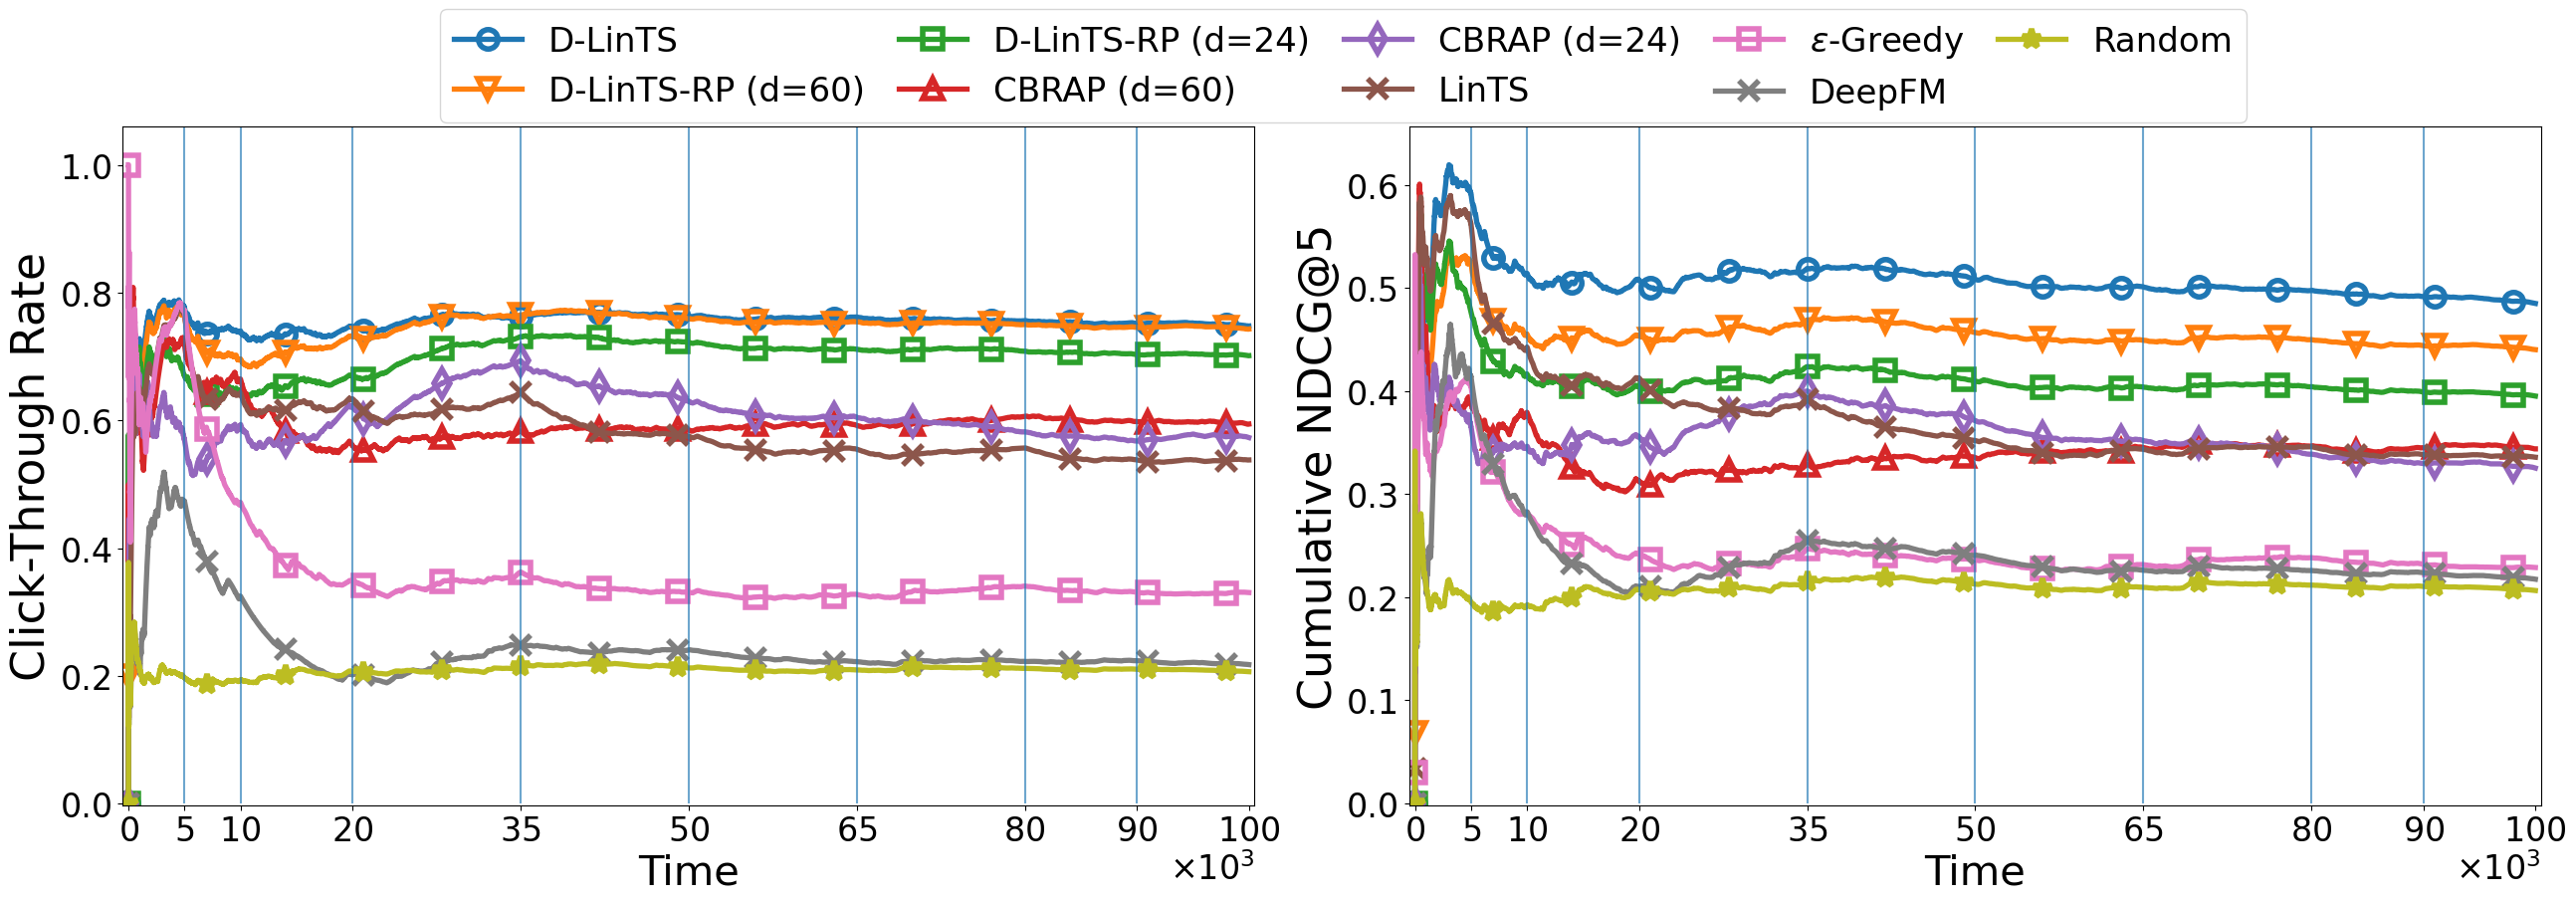

In [15]:
plot_ctrs_and_ndcg_together(reward_dict, ndcg_dict, CHANGE_POINTS)

In [16]:
def plot_ndcg(cumulative_ndcg_dict):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    
    N = 10
    
    cumulative_ndcg_list = sorted(
        [
            (l,r) for l, r in cumulative_ndcg_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, cumulative_ndcg in cumulative_ndcg_list:
        times = (range(1, len(cumulative_ndcg)+1))
        average_cumulative_ndcg = [cn/t for cn,t in zip(cumulative_ndcg, times)]
        ax.plot(average_cumulative_ndcg[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('Average Cumulative NDCG@5')
    ax.set_title('Average Cumulative NDCG@5 on MovieLens')

    plt.legend(bbox_to_anchor=(1.00, 1.0));
    plt.savefig(f'movielens_results_ndcg', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
    plt.show();

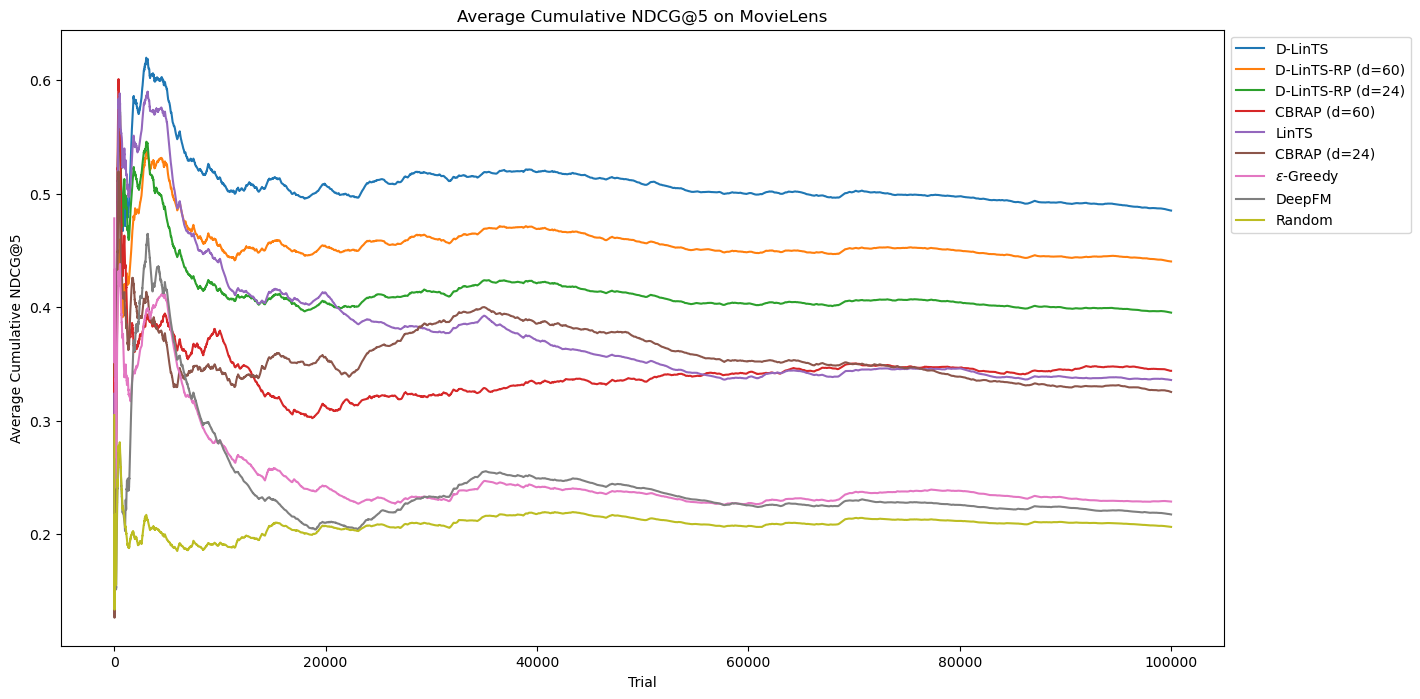

In [17]:
plot_ndcg(ndcg_dict)

In [18]:
def plot_ctrs_or_rewards(reward_dict, plot_type, change_points):
    if plot_type not in {'CTR', 'Cumulative reward', 'NDCG'}:
        raise ValueError("plot_type should be CTR or Cumulative reward or NDCG")
        
    fig, ax = plt.subplots(1,1, figsize=(14,9));
    N = 10
    sorted_reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('o', 'tab:blue'),
        1: ('v','tab:orange'),
        2: ('^','tab:green'),
        3: ('<','tab:red'),
        4: ('d','tab:purple'),
        5: ('>', 'tab:brown'),
        6: ('s', 'tab:pink'),
        7: ('x', 'tab:grey'),
        8: ('*', 'tab:olive'),
        9: ('h', 'tab:blue'),
        10: ('P','tab:orange'),
        11: ('p','tab:green'),
        12: ('8','tab:red'),
        13: ('<','tab:purple'),
        14: ('X', 'tab:brown'),
        15: ('v', 'xkcd:azure'),
    }
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        times = (range(1, len(reward)+1))
        
        mark, color = ind_to_params[ind]
        cumulative = [r for r,t in zip(reward, times)]
        cumulative_over_time = [r/t for r,t in zip(reward, times)]
        if plot_type in {'CTR', 'NDCG'}:
            to_plot = cumulative_over_time
        else:
            to_plot = cumulative
        max_vline=max(max_vline, max(to_plot[N:]))
            
        ax.plot(
            to_plot[N:], label=label,
                marker=mark, markevery=7000, markersize=11, markeredgewidth=2.5,
                fillstyle='none', color=color,
                linewidth=3.2,
        )
        
    reward_change_points = change_points[1:-1]
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, alpha=0.45
    )    
     
    extraticks = change_points
    plt.xticks(extraticks, rotation=30, fontsize=23)
    plt.yticks(fontsize=23)
    
    ax.set_xlabel('Time Step', fontsize=36)
    if plot_type == 'CTR':
        ylabel = 'Click-Through Rate'
        plot_name = 'ctr'
    elif plot_type == 'Cumulative reward':
        ylabel = 'Cumulative reward'
        plot_name = 'reward'
    elif plot_type == 'NDCG':
        ylabel = 'Cumulative NDCG@5'
        plot_name = 'ndcg'

    ax.set_ylabel(f'{ylabel}', fontsize=36)
    ax.set_ylim(-0.01, None)
    ax.set_xlim(-500, 100500)

    if plot_type == 'NDCG':
        size = 20
    else:
        size= 20
        
    
    plt.legend(prop={'size': size}, ncol=3, bbox_to_anchor=(0.05, 1.222), loc='upper left',);

    
    plt.savefig(f'plotting/movielens_results_{plot_name}', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
    plt.show();

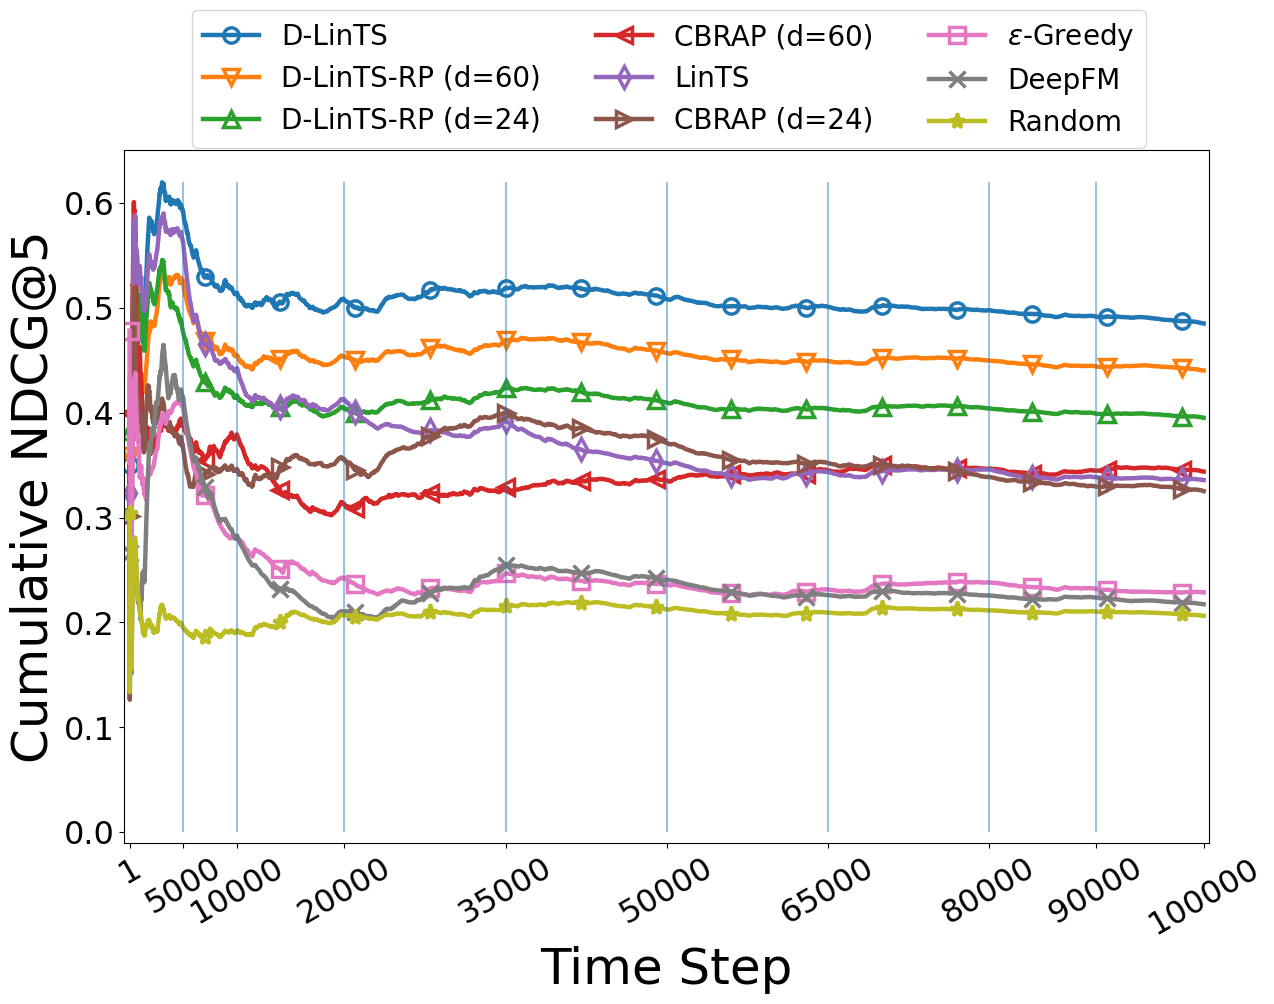

In [19]:
plot_ctrs_or_rewards(ndcg_dict, "NDCG", CHANGE_POINTS);

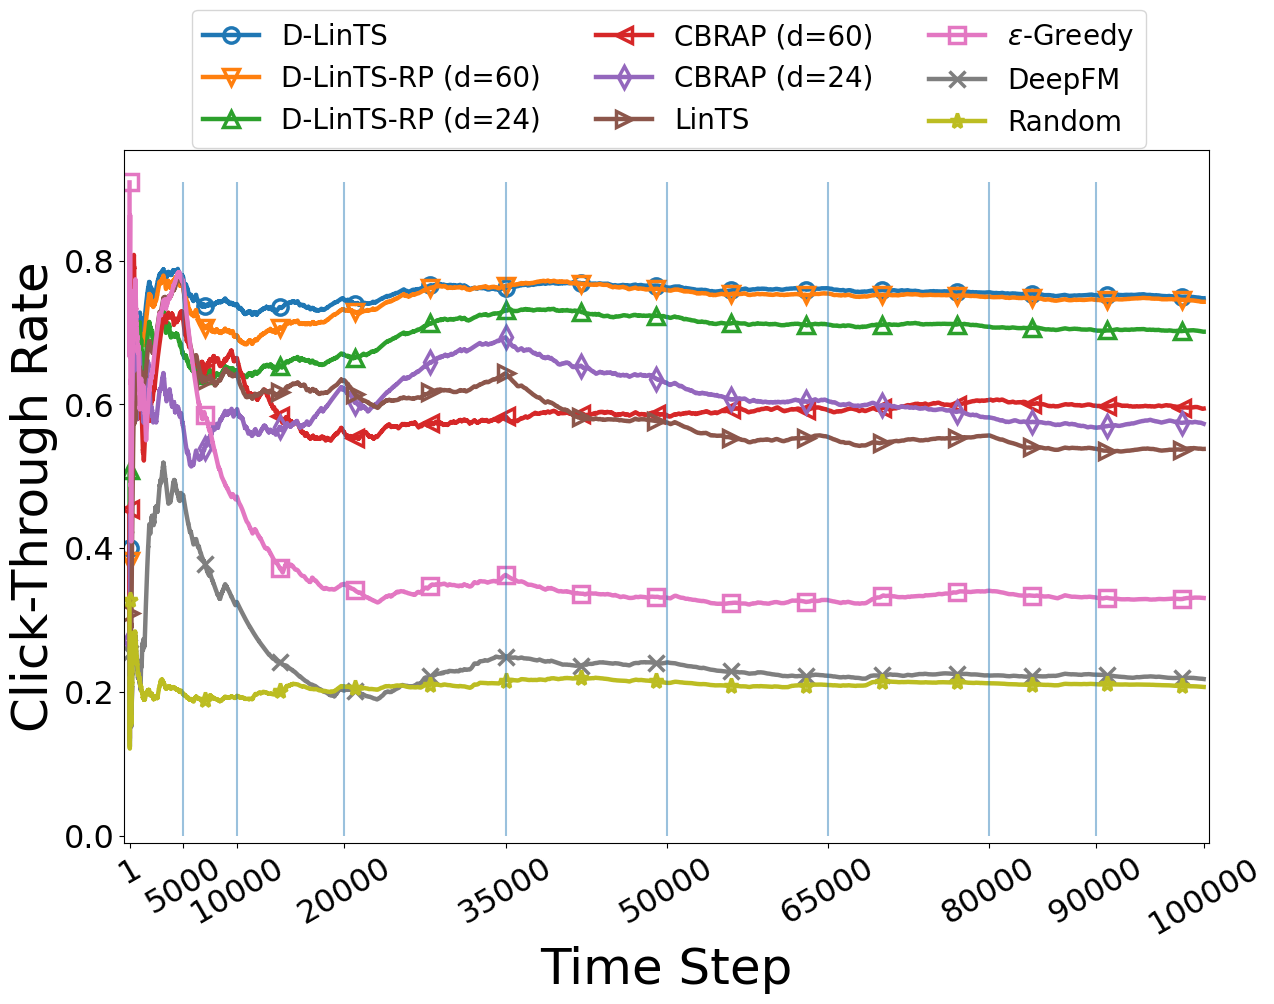

In [20]:
plot_ctrs_or_rewards(reward_dict, "CTR", CHANGE_POINTS);

In [21]:
# plot_ctrs_or_rewards(reward_dict, "Cumulative reward", CHANGE_POINTS);

In [22]:
print('Time')
{k: round(v,1) for k, v in time_dict.items()}

Time


{'D-LinTS-RP (d=120, gamma=0.99, a=0.1)': 1753.4,
 'CBRAP (d=12, alpha=0.6)': 1645.8,
 'E-Greedy (epsilon=0.001)': 686.7,
 'DeepFM': 3791.9,
 'D-LinTS-RP (d=24, gamma=0.99, a=0.1)': 1109.2,
 'CBRAP (d=60, alpha=0.6)': 1989.3,
 'LinearTS (nu=0.3)': 1370.9,
 'CBRAP (d=120, alpha=0.6)': 2440.3,
 'D-LinTS-RP (d=6, gamma=0.99, a=0.1)': 1027.4,
 'LinUCB (alpha=0.7)': 2452.2,
 'CBRAP (d=24, alpha=0.6)': 1917.0,
 'D-LinTS-RP (d=12, gamma=0.99, a=0.1)': 1054.9,
 'RandomPolicy': 857.8,
 'DLinTS (gamma=0.99, a=0.1)': 1739.8,
 'CBRAP (d=6, alpha=0.6)': 1647.7,
 'D-LinTS-RP (d=60, gamma=0.99, a=0.1)': 1231.5}

In [23]:
print('Reward')
[(k,v[-1][0]) for k,v in reward_dict.items()]

Reward


[('$\\epsilon$-Greedy', 33066.4),
 ('DeepFM', 21792.2),
 ('D-LinTS-RP (d=24)', 70130.0),
 ('CBRAP (d=60)', 59425.0),
 ('LinTS', 53814.0),
 ('CBRAP (d=24)', 57314.0),
 ('Random', 20683.4),
 ('D-LinTS', 74771.6),
 ('D-LinTS-RP (d=60)', 74294.6)]

In [24]:
print('NDCG')
[(k, round(v[-1][0],1)) for k,v in ndcg_dict.items()]

NDCG


[('$\\epsilon$-Greedy', 22866.9),
 ('DeepFM', 21731.2),
 ('D-LinTS-RP (d=24)', 39509.2),
 ('CBRAP (d=60)', 34382.5),
 ('LinTS', 33572.3),
 ('CBRAP (d=24)', 32521.0),
 ('Random', 20634.6),
 ('D-LinTS', 48499.1),
 ('D-LinTS-RP (d=60)', 44014.6)]

In [25]:
# # d =50% how much reward drops
# ((rewards[-1] - rewards[-2])/ rewards[-1]) * 100

In [26]:
# # d =50% how much time drops
# ((times[-1] - times[-2])/ times[-1]) * 100

In [27]:
dims = [6,12,24,60,120]
times = [1027.4, 1054.9, 1109.2, 1231.5,  1753.4]
rewards = [59379.8, 66628.6, 70130.0, 74294.6, 74379.8]

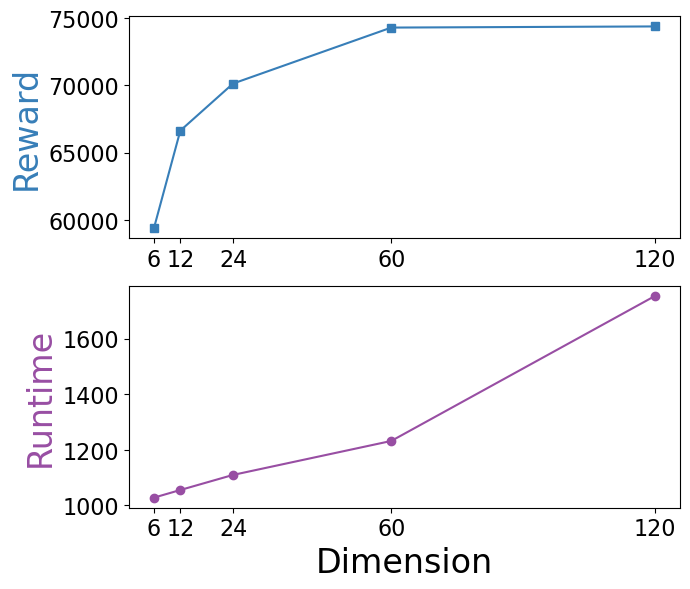

In [28]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

c1 = CB_color_cycle[0]
c2 = CB_color_cycle[5]

fig, axs = plt.subplots(2, figsize=(7, 6))

ax = axs[0]
ax2 = axs[1]

ax.plot(dims, rewards, color=c1, marker='s', label='Reward')
ax.set_ylabel('Reward', color=c1, fontsize=24)

ax.set_xticks(dims)
ax.tick_params(axis='both', labelsize=16)

ax2.plot(dims, times, color=c2, marker='o', label='Runtime')
ax2.set_ylabel('Runtime', color=c2, fontsize=24)
ax2.set_xlabel('Dimension', fontsize=24)
ax2.set_xticks(dims)
ax2.tick_params(axis='both', labelsize=16)


# plt.yticks(fontsize=16)
# fig.legend(loc='lower right', fontsize=15, bbox_to_anchor=(0.85, 0.215))
plt.tight_layout()
plt.savefig(f'plotting/movielens_runtime', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
plt.show()